In [1]:
import numpy as np
import scipy.io as sio
import os
from scipy.signal import spectrogram, istft
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
primary_order = ["power", "forward", "backward", "up", "down"]

def load_data(mic_dir, us_dir):
    
    mic_paths, mic_labels = [], []
    for root, _, files in os.walk(mic_dir):
        for fname in files:
            if fname.endswith(".mat"):
                mic_paths.append(os.path.join(root, fname))
                mic_labels.append(fname.split("_")[1].lower())

    us_paths, us_labels = [], []
    for root, _, files in os.walk(us_dir):
        for fname in files:
            if fname.endswith(".mat"):
                us_paths.append(os.path.join(root, fname))
                us_labels.append(fname.split("_")[1].lower())

    mic_paths  = np.array(mic_paths)
    mic_labels = np.array(mic_labels)
    us_paths   = np.array(us_paths)
    us_labels  = np.array(us_labels)

    if not np.array_equal(mic_labels, us_labels):
        raise ValueError("MIC and US labels don’t line up!")

    def chunk_num(p):
        stem = Path(p).stem               # e.g. "..._chunk01"
        return int(stem.split("_")[-1][5:])

    def label_rank(lbl):
        try:
            return primary_order.index(lbl)
        except ValueError:
            return len(primary_order)

    combined = sorted(
        zip(mic_paths, us_paths, mic_labels),
        key=lambda triple: (label_rank(triple[2]), chunk_num(triple[0]))
    )
    mic_paths, us_paths, labels_all = map(np.array, zip(*combined))

    # split per label  →  train(20) / test(2)
    train_mic, train_us, train_lbl = [], [], []
    test_mic,  test_us,  test_lbl  = [], [], []

    for lbl in primary_order:
        idxs = np.where(labels_all == lbl)[0]
        if len(idxs) < 22:
            raise ValueError(f"Need 22 chunks for '{lbl}', got {len(idxs)}")
        tr, te = idxs[:20], idxs[20:22]

        train_mic.extend (mic_paths[tr])
        train_us .extend(us_paths [tr])
        train_lbl.extend(labels_all[tr])

        test_mic .extend(mic_paths[te])
        test_us  .extend(us_paths [te])
        test_lbl .extend(labels_all[te])

    # shuffle training set
    train_mic = np.array(train_mic)
    train_us  = np.array(train_us)
    train_lbl = np.array(train_lbl)

    perm = np.random.permutation(len(train_mic))
    train_mic = train_mic[perm]
    train_us  = train_us [perm]
    train_lbl = train_lbl[perm]

    test_mic = np.array(test_mic)
    test_us  = np.array(test_us)
    test_lbl = np.array(test_lbl)

    return train_mic, train_us, train_lbl, test_mic, test_us, test_lbl


In [3]:
train_mic, train_us, train_labels, \
test_mic,  test_us,  test_labels = load_data(
    mic_dir="MIES_data/Mic/CHUNKS",
    us_dir ="MIES_data/US/CHUNKS"
)

print("Train:", train_mic.shape, train_labels.shape)  # (100,), (100,)
print("Test: ", test_mic.shape,  test_labels.shape)   # (10,) , (10,)

Train: (100,) (100,)
Test:  (10,) (10,)


In [5]:
# build your mapping
label2idx = {lbl: i for i, lbl in enumerate(primary_order)}

train_labels = np.array([ label2idx[l] for l in train_labels ], dtype=np.int32)
test_labels  = np.array([ label2idx[l] for l in test_labels  ], dtype=np.int32)


In [ ]:
_MEL_FILTER = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=64,
    num_spectrogram_bins=1024//2 + 1,  # 513
    sample_rate=25_000,
    lower_edge_hertz=0.0,
    upper_edge_hertz=12_500.0,         # fs/2
    dtype=tf.float32,
)

def mic_mel_spec_tf(
    signal,
    fs: int = 25_000,
    n_fft: int = 1024,
    hop_length: int = 256,
    n_mels: int = 64,
    power: float = 2.0,
    to_db: bool = True,
):
    """
    Compute a (log‑)Mel spectrogram from a 1‑D mono signal tensor.
    Works inside tf.data / keras.Sequence pipelines (no .numpy() call needed).
    Returns: Tensor shape (time_frames, n_mels)  dtype float32
    """

    signal = tf.cast(signal, tf.float32)

    stft = tf.signal.stft(
        signal,
        frame_length=n_fft,
        frame_step=hop_length,
        fft_length=n_fft,
        window_fn=tf.signal.hann_window,  # good default
        pad_end=False,
    )
    spectrogram = tf.abs(stft) ** power   # (frames, n_fft//2+1)
    
    with tf.device('/CPU:0'):
        mel_filter = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=n_mels,
            num_spectrogram_bins=n_fft // 2 + 1,
            sample_rate=fs,
            lower_edge_hertz=0.0,
            upper_edge_hertz=fs / 2.0,
            dtype=tf.float32,
        )

    mel_spec = tf.matmul(spectrogram, mel_filter)  # (frames, n_mels)

    if to_db:
        amin = 1e-10  # avoid log(0)
        mel_spec = 10.0 * tf.math.log(tf.maximum(mel_spec, amin)) / tf.math.log(10.0)
        mel_spec = tf.clip_by_value(mel_spec, -80.0, 20.0)
    return mel_spec              


2025-04-20 00:48:57.387465: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-20 00:48:57.387525: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-20 00:48:57.387539: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-20 00:48:57.387565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-20 00:48:57.387582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
def us_bandpassed_spec_tf(
    signal,
    fs: int = 100_000,           # ultrasound sampling rate [Hz]
    low_cut: float = 25_000.0,   # keep ≥ 25 kHz …
    high_cut: float = 50_000.0,  # … and ≤ 60 kHz   (must be ≤ fs/2)
    n_fft: int = 2048,
    hop_length: int = 512,
    power: float = 2.0,          # 1.0 → magnitude, 2.0 → power
    to_db: bool = True,
):

    nyq = fs / 2.0
    if high_cut > nyq:
        raise ValueError(
            f"`high_cut` ({high_cut/1e3:.1f} kHz) must be < Nyquist ({nyq/1e3:.1f} kHz). "
            "Sample faster or lower `high_cut`."
        )
    if low_cut <= 0.0:
        raise ValueError("`low_cut` must be > 0 Hz.")

    signal = tf.reshape(signal, [-1])
    signal = tf.cast(signal, tf.float32)

    sig_len = tf.shape(signal)[0]
    tf.debugging.assert_positive(sig_len, message="Empty mic signal!")

    tf.debugging.assert_positive(n_fft,        message="n_fft is 0")
    tf.debugging.assert_positive(hop_length,   message="hop_length is 0")
    
    # ---------- STFT ----------
    stft = tf.signal.stft(
        signal,
        frame_length=n_fft,
        frame_step=hop_length,
        fft_length=n_fft,
        window_fn=tf.signal.hann_window,
        pad_end=True,
    )                                     
    spec = tf.abs(stft) ** power         

    freqs = tf.linspace(0.0, nyq, n_fft // 2 + 1)   # (n_fft//2 + 1,)
    band_mask = (freqs >= low_cut) & (freqs <= high_cut)
    kept_indices = tf.where(band_mask)[:, 0]        # 1‑D int32

    spec_band = tf.gather(spec, kept_indices, axis=-1)   # (T, kept_bins)
    f_band    = tf.gather(freqs, kept_indices)           # (kept_bins,)

    if to_db:
        spec_band = 10.0 * tf.math.log(tf.maximum(spec_band, 1e-10)) / tf.math.log(10.0)
        spec_band = tf.clip_by_value(spec_band, -80.0, 20.0)          # optional

    return spec_band

In [7]:
def tf_dataloader(
    mic_paths,
    us_paths,
    labels,
    batch_size: int = 16,
    shuffle: bool = True,
):

    ds = tf.data.Dataset.from_tensor_slices(
        (mic_paths, us_paths, labels)
    )

    if shuffle:
        ds = ds.shuffle(len(mic_paths), reshuffle_each_iteration=True)

    def _load_pair(mic_path, us_path, label):
        def _py_loader(m_path, u_path):
            # 1. load *.mat (SciPy runs in Python space)
            mic_sig = sio.loadmat(m_path.numpy().decode("utf-8"))["x_chunk"].squeeze()
            mic_sig = mic_sig.astype(np.float32)
            us_sig  = sio.loadmat(u_path.numpy().decode("utf-8"))["x_chunk"].squeeze()
            us_sig  = us_sig.astype(np.float32)
            
            tf.debugging.assert_positive(tf.shape(mic_sig)[0])
            # 2. time‑series → spectrogram tensors
            mic_spec = mic_mel_spec_tf(mic_sig)
            us_spec  = us_bandpassed_spec_tf(us_sig)

            return mic_spec, us_spec

        mic_spec, us_spec = tf.py_function(
            func=_py_loader,
            inp=[mic_path, us_path],
            Tout=[tf.float32, tf.float32],
        )

        # Suppose you decide every mic spectrogram will be padded/truncated to exactly 192 frames:
        mic_spec = tf.pad(mic_spec,
                        [[0, 192 - tf.shape(mic_spec)[0]], [0, 0]],
                        constant_values=-80.0)[:192, :]
        mic_spec.set_shape([192, 64])

        # And every US spectrogram to 391 frames:
        us_spec = tf.pad(us_spec,
                        [[0, 391 - tf.shape(us_spec)[0]], [0, 0]],
                        constant_values=-80.0)[:391, :]
        us_spec.set_shape([391, 513])

        return (mic_spec, us_spec), label   # Keras expects (inputs, target)

    ds = ds.map(_load_pair)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [9]:
train_ds = tf_dataloader(
    mic_paths=train_mic,
    us_paths=train_us,
    labels=train_labels,
    batch_size=16,
    shuffle=True,
)
test_ds = tf_dataloader(
    mic_paths=test_mic,
    us_paths=test_us,
    labels=test_labels,
    batch_size=10,
    shuffle=False,
)

In [19]:
NUM_CLASSES = 5  # power, forward, backward, up, down

def resNet1D_block(x, filters, kernel_size=3, strides=1):
    """
    1D ResNet block with residual connection.
    """
    shortcut = x
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = LayerNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = LayerNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

mic_in = Input(shape=(192, 64))
x1 = LayerNormalization()(mic_in)
x1 = Conv1D(32, 3, padding='same')(x1)
x1 = Activation('relu')(x1)
x1 = resNet1D_block(x1, 32)
x1 = AveragePooling1D(pool_size=4)(x1)

us_in = Input(shape=(391, 513))
x2 = LayerNormalization()(us_in)
x2 = Conv1D(32, 3, padding='same')(x2)
x2 = Activation('relu')(x2)
x2 = resNet1D_block(x2, 32)
x2 = AveragePooling1D(pool_size=8)(x2)

x = Concatenate(axis=-1)([x1, x2])
x = Conv1D(64, 3, padding='same')(x)
x = LayerNormalization()(x)
x = Activation('relu')(x)

attn = MultiHeadAttention(num_heads=4, key_dim=16)
x_attn = attn(query=x, value=x, key=x)
x = Add()([x, x_attn])
x = LayerNormalization()(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
out = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=[mic_in, us_in], outputs=out, name='fusion_model')

In [20]:
model.summary()

Model: "fusion_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 192, 64)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 391, 513)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 64)   │        128 │ input_layer_6[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 391, 513)  │      1,026 │ input_layer_7[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 192, 32)   │      6,176 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 391, 32)   │     49,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 192, 32)   │          0 │ conv1d_13[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 391, 32)   │          0 │ conv1d_16[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 192, 32)   │      3,104 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 391, 32)   │      3,104 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 32)   │         64 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 391, 32)   │         64 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 192, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 391, 32)   │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 192, 32)   │      3,104 │ re_lu_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 391, 32)   │      3,104 │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 192, 32)   │         64 │ conv1d_15[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 391, 32)   │         64 │ conv1d_18[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 192, 32)   │          0 │ layer_normalizat… │
│                     │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 100,775 (393.65 KB)

 Trainable params: 100,775 (393.65 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# callbacks
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)
ckpt = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# train
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=test_ds,
    callbacks=[es, ckpt]
)

# final evaluation
loss, acc = model.evaluate(test_ds)
print(f"Test loss: {loss:.4f}, accuracy: {acc:.4%}")

Epoch 1/50


/opt/anaconda3/envs/dl_env/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_129', 'keras_tensor_141']. Received: the structure of inputs=('*', '*')
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.3029 - loss: 1.5970
Epoch 1: val_loss improved from inf to 1.22583, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 791ms/step - accuracy: 0.3050 - loss: 1.5899 - val_accuracy: 0.6000 - val_loss: 1.2258
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.5433 - loss: 1.2060
Epoch 2: val_loss improved from 1.22583 to 0.79468, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 545ms/step - accuracy: 0.5479 - loss: 1.1981 - val_accuracy: 0.6000 - val_loss: 0.7947
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.7544 - loss: 0.8143
Epoch 3: val_loss improved from 0.79468 to 0.44175, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 622ms/step - accuracy: 0.7526 - loss: 0.8128 - val_accuracy: 1.0000 - val_loss: 0.4418
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.9559 - loss: 0.4832
Epoch 4: val_loss improved from 0.44175 to 0.25379, saving model to best_model

In [23]:
model.save("resnet_fusion_model.keras")

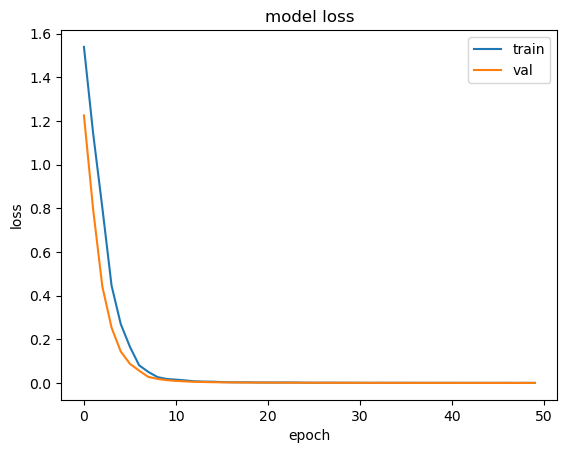

In [26]:
# plot loss curve from training
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

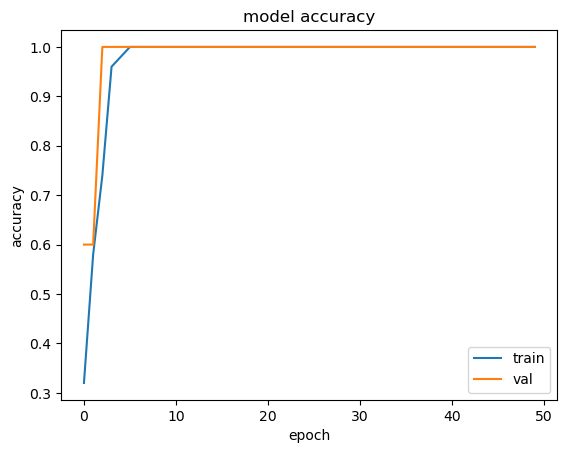

In [27]:
# training accuracy plot
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()